In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
jokes = pd.read_csv('../Data/processed_jokes.csv', delimiter=',',index_col=0)
jokes.head()

,Text,CharCount,WordCount,AverageRating,StdDev,Popularity
JokeID,,,,,,
1,"A man visits the doctor. The doctor says, ""I h...",165,30,NaN,NaN,0
2,This couple had an excellent relationship goin...,375,71,NaN,NaN,0
3,Q. What's 200 feet long and has 4 teeth? A. Th...,85,18,NaN,NaN,0
4,Q. What's the difference between a man and a t...,108,21,NaN,NaN,0
5,Q. What's O. J. Simpson's web address? A. Slas...,88,14,-2.034618,5.423289,566


**Simple Content based Filtering**

In [3]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(jokes['Text'].fillna(''))
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [8]:
def get_recommendations(joke_id, sim_matrix, top_n=5):
    if joke_id < 1 or joke_id > 150:
        print("Invalid Joke Id")
        return

    idx = jokes.index.get_loc(joke_id)
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1],
                        reverse=True)[1:top_n + 1]

    indices = [i[0] for i in sim_scores]
    return jokes.iloc[indices][['Text']]
recc = get_recommendations(40, cosine_sim)
recc

,Text
JokeID,
90,Q: How many programmers does it take to change...
58,How many teddy bears does it take to change a ...
74,Q: How many stalkers does it take to change a ...
32,A man arrives at the gates of heaven. St. Pete...
86,A neutron walks into a bar and orders a drink....


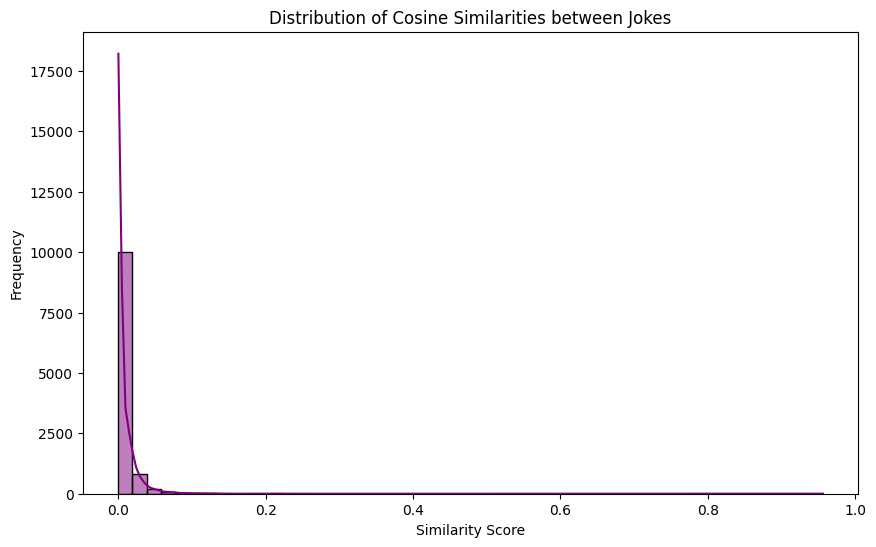

In [5]:
sim_values = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]

plt.figure(figsize=(10, 6))
sns.histplot(sim_values,bins=50, kde=True, color='purple')
plt.title('Distribution of Cosine Similarities between Jokes')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

**Content based filtering with LSA**

Components: 2 | Explained Variance: 0.0205
Components: 7 | Explained Variance: 0.0735
Components: 12 | Explained Variance: 0.1175
Components: 17 | Explained Variance: 0.1570
Components: 22 | Explained Variance: 0.1958
Components: 27 | Explained Variance: 0.2332
Components: 32 | Explained Variance: 0.2698
Components: 37 | Explained Variance: 0.3053
Components: 42 | Explained Variance: 0.3411
Components: 47 | Explained Variance: 0.3759
Components: 52 | Explained Variance: 0.4100
Components: 57 | Explained Variance: 0.4439
Components: 62 | Explained Variance: 0.4780
Components: 67 | Explained Variance: 0.5117
Components: 72 | Explained Variance: 0.5451
Components: 77 | Explained Variance: 0.5785
Components: 82 | Explained Variance: 0.6105
Components: 87 | Explained Variance: 0.6434
Components: 92 | Explained Variance: 0.6754
Components: 97 | Explained Variance: 0.7067
Components: 102 | Explained Variance: 0.7385
Components: 107 | Explained Variance: 0.7693
Components: 112 | Explained Vari

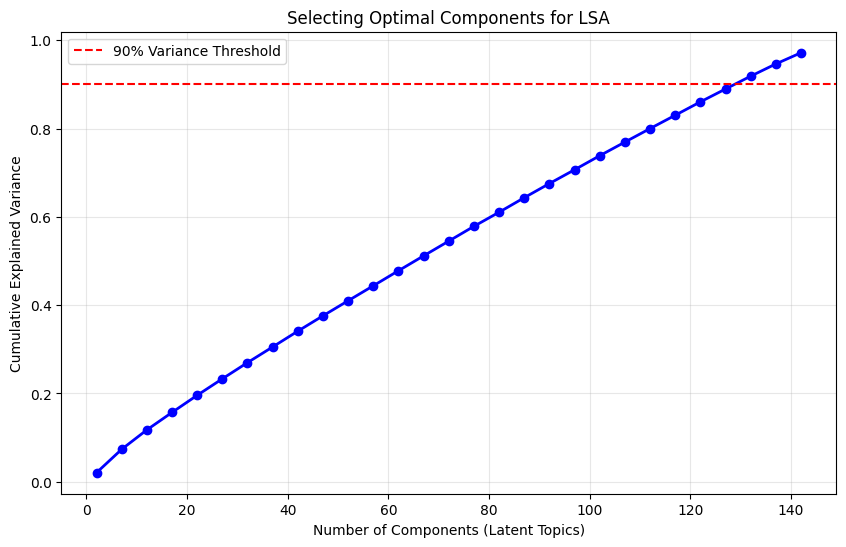

In [60]:
def experiment_lsa_components(tfidf_matrix, components_range):
    explained_variances = []

    for n in components_range:
        svd = TruncatedSVD(n_components=n, random_state=42)
        svd.fit(tfidf_matrix)
        total_variance = svd.explained_variance_ratio_.sum()
        explained_variances.append(total_variance)
        print(f"Components: {n} | Explained Variance: {total_variance:.4f}")

    return explained_variances

n_comp_list = np.arange(2,145,step=5)
variances = experiment_lsa_components(tfidf_matrix, n_comp_list)

plt.figure(figsize=(10, 6))
plt.plot(n_comp_list, variances, 'bo-', linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')

plt.title('Selecting Optimal Components for LSA')
plt.xlabel('Number of Components (Latent Topics)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The analysis of the cumulative explained variance revealed a near-linear growth, indicating a high degree of semantic diversity across the joke corpus. We selected 110 componets to achieve optimal balance between dimensionality reduction and information preservation.This configuration captures 80% of the total variance.

In [6]:
svd_final = TruncatedSVD(n_components=110, random_state=42)
lsa_matrix_final = svd_final.fit_transform(tfidf_matrix)
cosine_sim_lsa = cosine_similarity(lsa_matrix_final)

In [18]:
test_id = 10 
print(jokes.iloc[test_id,0])
print("--- Text Matching (TF-IDF - only words) ---")
print(get_recommendations(test_id, cosine_sim)) 

print("\n--- Semantic similarity (LSA 110 components) ---")
print(get_recommendations(test_id, cosine_sim_lsa))

Q. What do a hurricane, a tornado, and a redneck divorce all have in common? A. Someone's going to lose a trailer...
--- Text Matching (TF-IDF - only words) ---
                                                     Text
JokeID                                                   
7       How many feminists does it take to screw in a ...
37      A Jewish young man was seeing a psychiatrist f...
90      Q: How many programmers does it take to change...
17      How many men does it take to screw in a light ...
6       Bill and Hillary Clinton are on a trip back to...

--- Semantic similarity (LSA 110 components) ---
                                                     Text
JokeID                                                   
7       How many feminists does it take to screw in a ...
37      A Jewish young man was seeing a psychiatrist f...
62      A group of managers were given the assignment ...
118     A man goes into a drug store and asks the phar...
18      A dog walks into Western Un

In [33]:
ratings = pd.read_csv('../Data/processed_ratings.csv',
                      delimiter=',',
                      header=None)
ratings_matrix = ratings.iloc[:,1:]
ratings_raw = ratings_matrix.replace(99, np.nan).values
mask = ~np.isnan(ratings_raw)

In [34]:
def create_svd_pipeline(n_components):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('svd', TruncatedSVD(n_components=n_components, random_state=42))
    ])

Components: 2 | RMSE: 4.3313
Components: 5 | RMSE: 3.9412
Components: 10 | RMSE: 3.5577
Components: 20 | RMSE: 3.1133
Components: 30 | RMSE: 2.8119
Components: 40 | RMSE: 2.5508
Components: 50 | RMSE: 2.3023
Components: 75 | RMSE: 1.7141
Components: 100 | RMSE: 1.1292
Components: 105 | RMSE: 1.0000
Components: 110 | RMSE: 0.8721


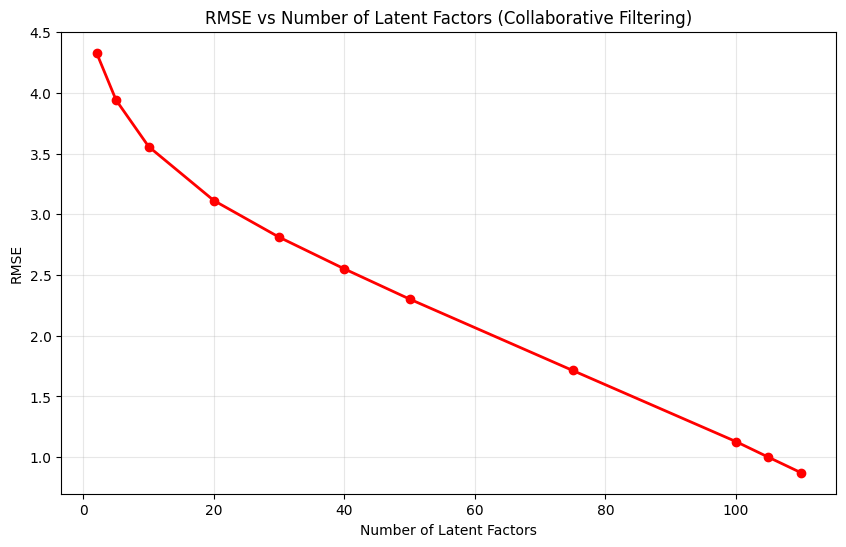

In [37]:
actual_values = ratings_raw[mask]
components_list = [2, 5, 10, 20, 30, 40, 50, 75, 100, 105, 110]
rmse_results = []

for n in components_list:
    pipe = create_svd_pipeline(n)

    user_features = pipe.fit_transform(ratings_raw)
    vt = pipe.named_steps['svd'].components_
    
    predicted_matrix = np.dot(user_features, vt)
    
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_matrix[mask]))
    rmse_results.append(rmse)
    print(f"Components: {n} | RMSE: {rmse:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(components_list, rmse_results, 'ro-', linewidth=2)
plt.title('RMSE vs Number of Latent Factors (Collaborative Filtering)')
plt.xlabel('Number of Latent Factors')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)
plt.show()